### **SAROJ DEVKOTA | UNIVERSITY ID: 2329255 | WORKSHEET 04**

**STEP 01: IMPORT LIBRARIES, SET RANDOM SEED AND DEFINE CONSTANTS**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Step 01: Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import zipfile
from google.colab import drive
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Step 02: Set Random Seed for Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# STEP 3: Define Constants
IMG_HEIGHT, IMG_WIDTH = 28, 28  # Image size (28x28 pixels)
NUM_CLASSES = 10  # Number of output classes (digits 0-9)
BATCH_SIZE = 128  # Number of images per training batch
EPOCHS = 20  # Total training epochs
VALIDATION_SPLIT = 0.2  # Portion of data used for validation (20%)

# Print the installed TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


**STEP 02: MOUNT GOOGLE DRIVE AND EXTRACT THE DATASET**



Since the dataset is stored as a .zip file in Google Drive, we first mount Drive to access it. Then, we extract the dataset to a temporary directory in Colab for easy use.

In [5]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive (force remount if needed)
drive.mount('/content/drive', force_remount=True)

def extract_zip_dataset(zip_path, extract_dir='/content/dataset'):
    """
    Unzips the dataset into a specified directory.

    Args:
        zip_path (str): Location of the .zip file in Google Drive.
        extract_dir (str): Destination folder for extracted files.

    Returns:
        str: Path to the extracted dataset folder.
    """
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    return extract_dir

# Define the correct zip file path
zip_file_path = "/content/drive/MyDrive/Machine learning/Copy of devnagari digit.zip"

# Extract the dataset
extract_dir = extract_zip_dataset(zip_file_path)

# Adjust for dataset structure
nested_dir = os.path.join(extract_dir, "DevanagariHandwrittenDigitDataset")
train_dir = os.path.join(nested_dir, "Train")
test_dir = os.path.join(nested_dir, "Test")

# Display dataset directories
print(f"Training data is located at: {train_dir}")
print(f"Testing data is located at: {test_dir}")

Mounted at /content/drive
Training data is located at: /content/dataset/DevanagariHandwrittenDigitDataset/Train
Testing data is located at: /content/dataset/DevanagariHandwrittenDigitDataset/Test


**STEP 03: LOAD AND PREPROCESS THE DATASET**

Images of Devanagari digits from the Train and Test directories are loaded, resized to 28x28 pixels, and normalized for consistency. The labels are then converted into a one-hot encoded format for training.

In [6]:
def load_images_from_folder(folder):
    """
    Load Devnagari digit images and their corresponding labels from a folder structure using PIL.

    Args:
        folder (str): Path to the folder (e.g., '/content/dataset/DevanagariHandwrittenDigitDataset/Train/').

    Returns:
        tuple: (images, labels) as NumPy arrays, where images are normalized and flattened.
    """
    images = []  # List to hold image data
    labels = []  # List to hold image labels
    class_names = [f"digit_{i}" for i in range(10)]  # Class names: digit_0 to digit_9

    # Iterate through each class folder (digit_0 to digit_9)
    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        if not os.path.isdir(class_path):  # Check if folder exists
            print(f"Warning: {class_path} not found, skipping.")  # Print warning if folder is missing
            continue
        label = int(class_name.split('_')[1])  # Extract label from folder name (e.g., digit_0 -> 0)

        # Load images for the current class
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = Image.open(img_path).convert("L")  # Open image and convert to grayscale
                img = img.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize image to 28x28
                img = np.array(img) / 255.0  # Normalize image
                images.append(img)  # Add image to list
                labels.append(label)  # Add label to list
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")  # Print error message if image fails to load

    # Convert lists to NumPy arrays, reshape images, and one-hot encode labels
    images = np.array(images).reshape(-1, IMG_HEIGHT * IMG_WIDTH)
    labels = to_categorical(np.array(labels), NUM_CLASSES)  # One-hot encode labels
    return images, labels

# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)  # Load training images and labels
x_test, y_test = load_images_from_folder(test_dir)    # Load testing images and labels

# Print shapes of the training and test sets
print(f"Training data shape: {x_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}, Test labels shape: {y_test.shape}")

Training data shape: (17000, 784), Training labels shape: (17000, 10)
Test data shape: (3000, 784), Test labels shape: (3000, 10)


**STEP 04: EXPLORE THE DATASET**

Sample images are displayed, and the distribution of classes is analyzed to verify that the dataset is balanced.

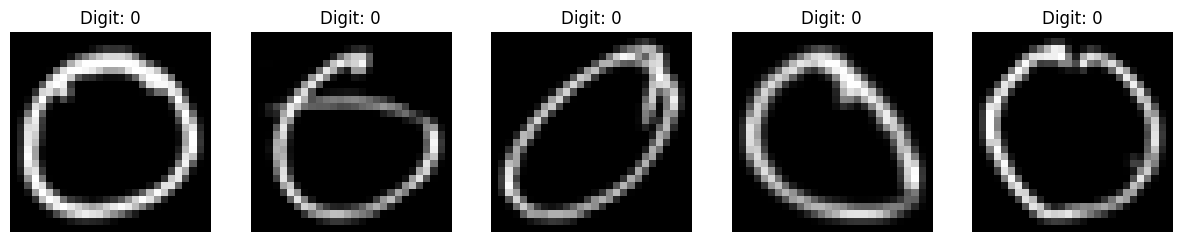


Class distribution in Full Training Set:
Class 0: 1700 samples
Class 1: 1700 samples
Class 2: 1700 samples
Class 3: 1700 samples
Class 4: 1700 samples
Class 5: 1700 samples
Class 6: 1700 samples
Class 7: 1700 samples
Class 8: 1700 samples
Class 9: 1700 samples

Class distribution in Training Split:
Class 0: 1700 samples
Class 1: 1700 samples
Class 2: 1700 samples
Class 3: 1700 samples
Class 4: 1700 samples
Class 5: 1700 samples
Class 6: 1700 samples
Class 7: 1700 samples

Class distribution in Validation Split:
Class 8: 1700 samples
Class 9: 1700 samples

Class distribution in Test Set:
Class 0: 300 samples
Class 1: 300 samples
Class 2: 300 samples
Class 3: 300 samples
Class 4: 300 samples
Class 5: 300 samples
Class 6: 300 samples
Class 7: 300 samples
Class 8: 300 samples
Class 9: 300 samples


In [7]:
def visualize_samples(x_data, y_data, num_samples=5):
    """
    Display a few sample images from the dataset along with their corresponding labels.

    Args:
        x_data (np.ndarray): Flattened image data.
        y_data (np.ndarray): One-hot encoded labels.
        num_samples (int): Number of sample images to display.
    """
    plt.figure(figsize=(15, 3))  # Set figure size
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)  # Create a subplot for each sample
        img = x_data[i].reshape(IMG_HEIGHT, IMG_WIDTH)  # Reshape to 28x28 image
        label = np.argmax(y_data[i])  # Get the label (index of the highest value in one-hot encoding)
        plt.imshow(img, cmap='gray')  # Display the image in grayscale
        plt.title(f"Digit: {label}")  # Set the title to show the digit label
        plt.axis('off')  # Hide the axis
    plt.show()

def check_class_distribution(y_data, set_name="Dataset"):
    """
    Check and display the distribution of classes in the dataset.

    Args:
        y_data (np.ndarray): One-hot encoded labels.
        set_name (str): Name of the dataset (e.g., 'Training Set', 'Test Set').
    """
    labels = np.argmax(y_data, axis=1)  # Convert one-hot encoded labels to integer labels
    unique, counts = np.unique(labels, return_counts=True)  # Count the occurrences of each label
    print(f"\nClass distribution in {set_name}:")
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples")  # Print the class and its count

# Visualize 5 samples from the training dataset
visualize_samples(x_train, y_train, num_samples=5)

# Split the training set into training and validation sets
val_split = 0.2  # 20% of the data will be used for validation
num_train = int((1 - val_split) * len(x_train))  # Calculate number of training samples
x_train_split, x_val_split = x_train[:num_train], x_train[num_train:]  # Split the data
y_train_split, y_val_split = y_train[:num_train], y_train[num_train:]  # Split the labels

# Check class distribution for full dataset and splits
check_class_distribution(y_train, "Full Training Set")
check_class_distribution(y_train_split, "Training Split")
check_class_distribution(y_val_split, "Validation Split")
check_class_distribution(y_test, "Test Set")

**STEP 05: BUILD THE MODEL**

A Fully Connected Neural Network is created with three hidden layers containing 64, 128, and 256 neurons. To help prevent overfitting, ReLU activations and dropout layers are incorporated.

In [8]:
def build_fcn_model():
    """
    Create a Fully Connected Neural Network (FCN) for Devnagari digit classification,
    utilizing ReLU activations and Dropout layers to prevent overfitting.

    Returns:
        keras.Model: Compiled FCN model with 3 hidden layers, dropout, and an output layer.
    """
    model = models.Sequential([
        layers.Input(shape=(IMG_HEIGHT * IMG_WIDTH,)),  # Input layer (flattened 28x28 image)
        layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons and ReLU activation
        layers.Dropout(0.3),  # Dropout layer to reduce overfitting (30% dropout)
        layers.Dense(128, activation='relu'),  # Second hidden layer with 128 neurons and ReLU activation
        layers.Dropout(0.3),  # Dropout layer (30% dropout)
        layers.Dense(256, activation='relu'),  # Third hidden layer with 256 neurons and ReLU activation
        layers.Dropout(0.3),  # Dropout layer (30% dropout)
        layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer with softmax activation for multi-class classification
    ])

    model.compile(
        optimizer='sgd',  # Stochastic Gradient Descent optimizer
        loss='categorical_crossentropy',  # Categorical crossentropy loss function for multi-class classification
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

# Build and display model summary
model = build_fcn_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,154 (367.79 KB)

 Trainable params: 94,154 (367.79 KB)

 Non-trainable params: 0 (0.00 B)

**STEP 06: TRAIN THE MODEL**

The model is trained for 20 epochs with a batch size of 128 and a 20% validation split. The data is shuffled to create a representative validation set, and early stopping is used to avoid overfitting.

In [9]:
def train_model(model, x_train, y_train):
    """
    Train the Fully Connected Neural Network (FCN) model with shuffled data and specified parameters.

    Args:
        model (keras.Model): The FCN model to train.
        x_train (np.ndarray): Training image data.
        y_train (np.ndarray): One-hot encoded training labels.

    Returns:
        History: Object containing the training history with loss and accuracy metrics.
    """
    # Shuffle the training data
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)  # Shuffle indices to ensure random data ordering
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]

    # Set up callbacks for early stopping and saving the best model
    callbacks = [
        ModelCheckpoint(filepath='/content/devnagari_fcn_best.keras', monitor='val_loss', save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=6)  # Stop training if validation loss does not improve for 6 epochs
    ]

    # Train the model
    history = model.fit(
        x_train_shuffled, y_train_shuffled,  # Shuffled training data
        batch_size=BATCH_SIZE,  # Batch size of 128
        epochs=EPOCHS,  # Train for 20 epochs
        validation_split=VALIDATION_SPLIT,  # 20% of data is used for validation
        callbacks=callbacks,  # Use early stopping and model checkpointing
        verbose=1  # Display progress during training
    )
    return history

# Train the model and store the training history
history = train_model(model, x_train, y_train)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.1097 - loss: 2.3103 - val_accuracy: 0.3062 - val_loss: 2.1634
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2224 - loss: 2.1596 - val_accuracy: 0.4853 - val_loss: 1.8768
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3568 - loss: 1.8939 - val_accuracy: 0.6750 - val_loss: 1.4252
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4712 - loss: 1.5662 - val_accuracy: 0.7568 - val_loss: 1.0526
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5455 - loss: 1.3063 - val_accuracy: 0.8038 - val_loss: 0.8071
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6134 - loss: 1.1018 - val_accuracy: 0.8341 - val_loss: 0.6508
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6697 - loss: 0.9568 - val_accuracy: 0.8521 - val_loss: 0.5530
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7016 - loss: 0.8504 - val_accuracy: 0

**STEP 07: VISUALISE TRAIN HISTORY**

The training and validation loss, as well as accuracy, are plotted to evaluate the model's performance throughout the training process.

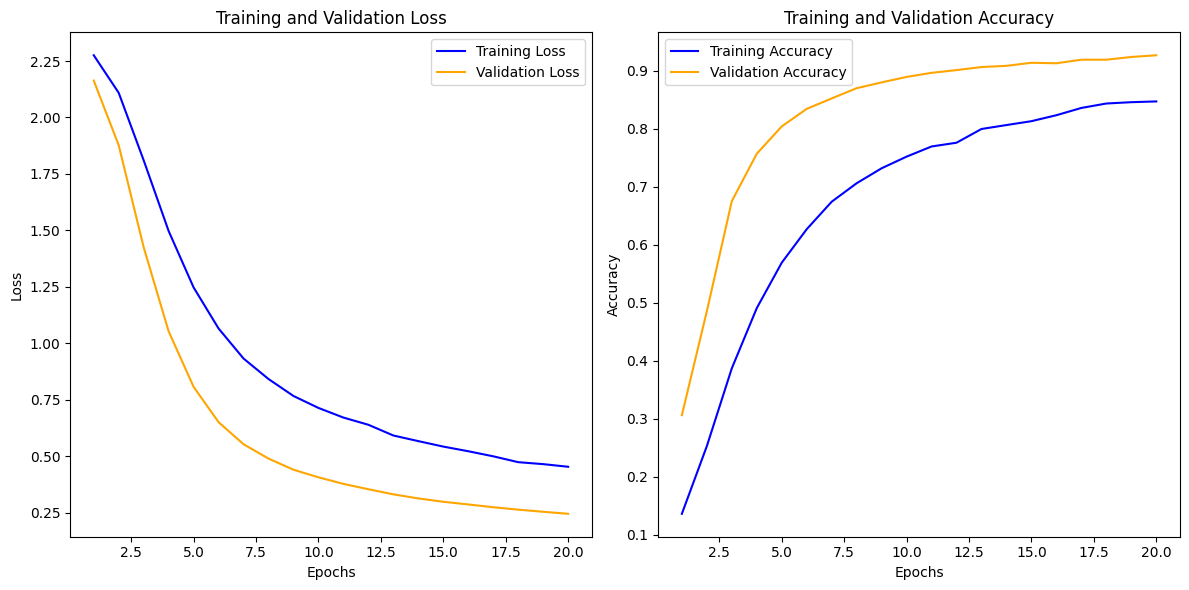

In [10]:
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy over epochs.

    Args:
        history (History): Training history object returned by model.fit().
    """
    # Extract loss and accuracy data for training and validation sets
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Create a figure to hold two subplots
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
    plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Visualize training history
plot_training_history(history)

**STEP 08: MODEL EVALUATION AND PREDICTION VISUALIZATION**

The model is tested on the test set, predictions are generated, and the results are displayed using a confusion matrix.

94/94 - 1s - 13ms/step - accuracy: 0.9260 - loss: 0.2518
Test Accuracy: 0.9260
Test Loss: 0.2518
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Predicted label for the first test image: 0
True label for the first test image: 0


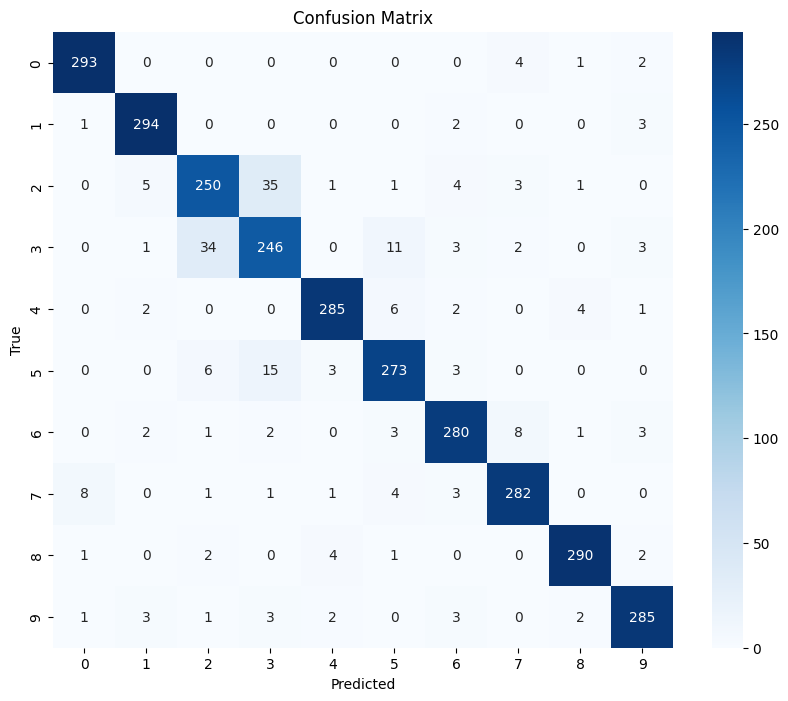

In [11]:
def evaluate_and_predict(model, x_test, y_test):
    """
    Evaluate the trained model on the test set, generate predictions, and visualize the results.

    Args:
        model (keras.Model): The trained FCN model.
        x_test (np.ndarray): Test image data.
        y_test (np.ndarray): One-hot encoded test labels.
    """
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Generate predictions from the model
    predictions = model.predict(x_test)
    predicted_labels = np.argmax(predictions, axis=1)  # Convert predictions to class labels
    true_labels = np.argmax(y_test, axis=1)  # Extract true labels

    # Display a sample prediction
    print(f"\nPredicted label for the first test image: {predicted_labels[0]}")
    print(f"True label for the first test image: {true_labels[0]}")

    # Visualize the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate and visualize predictions on the test set
evaluate_and_predict(model, x_test, y_test)

**STEP 09: SAVE AND LOAD THE MODEL**

The trained model is saved in the Keras format, and then reloaded to ensure it performs as expected.


Evaluating the reloaded model:
94/94 - 1s - 9ms/step - accuracy: 0.9260 - loss: 0.2518
Test Accuracy: 0.9260
Test Loss: 0.2518
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Predicted label for the first test image: 0
True label for the first test image: 0


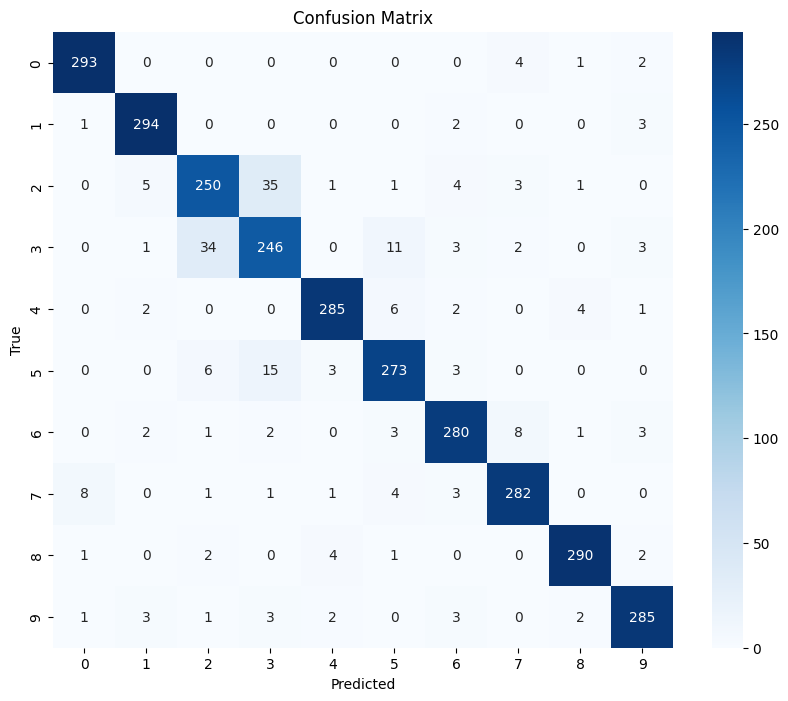

In [12]:
# Save the trained model
model.save('/content/devnagari_fcn_trained.keras')

# Reload the saved model
loaded_model = tf.keras.models.load_model('/content/devnagari_fcn_trained.keras')
print("\nEvaluating the reloaded model:")

# Evaluate and visualize predictions using the reloaded model
evaluate_and_predict(loaded_model, x_test, y_test)

**STEP 10: DOWNLOAD THE MODEL**

The saved model file is downloaded to the local machine for offline use.


In [13]:
from google.colab import files

# Download the saved model to the local machine
files.download('/content/devnagari_fcn_trained.keras')

# Notify the user that the model has been successfully downloaded
print("Model has been successfully downloaded to your local machine.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model has been successfully downloaded to your local machine.
